# NNs in an FRTB Framework

## Notebook Setup


In [1]:
# import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle  
from tensorflow.python.ops.numpy_ops import np_config
from itertools import product
np_config.enable_numpy_behavior()
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
# from scipy.stats import spearmanr
# from scipy.stats import ks_2samp 


from IPython.display import clear_output

from numpy.linalg import cholesky

In [2]:
!wget "https://www.1001fonts.com/download/latin-modern-roman.zip"
!mkdir Font
!unzip latin-modern-roman.zip -d Font

import matplotlib.font_manager as fm
import matplotlib

# fetch the name of font that was installed
path = "Font"
fontprop = fm.FontProperties(fname=path)

matplotlib.rcParams['font.family'] = fontprop.get_family()

clear_output()

In [3]:
# !rm -r {'PHD_Code'}
# !git clone https://github.com/Lolillosky/PHD_Code.git

import sys
sys.modules.pop
sys.path.insert(0,'PHD_Code/CODE')

clear_output()

In [4]:
tf.keras.backend.set_floatx('float64')

In [5]:
# PATH_DATA = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/DATA/"
# PATH_FIGS = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/FIGS/"
# PATH_MODELS = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/MODELS/"

PATH_DATA = "DATA/"
PATH_FIGS = "FIGS/"
PATH_MODELS = "MODELS_TEST/"

In [6]:
import Option_formulas
import Miscellanea
import Deep_learning_models
import ModelHandlers

In [7]:
Option_formulas.BlackTF(1.0,1.0,1.0,0,0.2,True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.07965565>

## Load Historical Data

In [8]:
hist_data = pd.read_excel(PATH_DATA + 'Hist_data.xlsx', index_col='Dates')

display(hist_data.head(3))
display(hist_data.tail(3))


Apple_Spot  Apple_Vol  IBM_Spot  IBM_Vol  JMP_Spot  JPM_Vol
Dates                                                                  
2010-01-01       7.526     37.458  125.0310   23.275     41.67   35.088
2010-01-04       7.643     37.428  126.5115   23.198     42.85   34.045
2010-01-05       7.656     38.004  124.9832   23.318     43.68   33.323

Apple_Spot  Apple_Vol  IBM_Spot  IBM_Vol  JMP_Spot  JPM_Vol
Dates                                                                  
2022-12-06      142.91     34.215    147.50   24.998    131.59   29.305
2022-12-07      140.94     34.771    147.27   25.134    131.50   29.658
2022-12-08      140.94     34.771    147.27   25.134    131.50   29.658

## Computation of 1d and 10d schocks

In [9]:
risk_horizon = 10
hist_data_length = 250

hist_schocks = pd.DataFrame(data = np.log(hist_data.iloc[risk_horizon:].values/ hist_data.iloc[0:-risk_horizon].values),
                            index =  hist_data.index[risk_horizon:], columns = hist_data.columns) 

hist_schocks = hist_schocks.iloc[-hist_data_length:]

hist_schocks_daily = pd.DataFrame(data = np.log(hist_data.iloc[1:].values/ hist_data.iloc[0:-1].values),
                            index =  hist_data.index[1:], columns = hist_data.columns) 

hist_schocks_daily = hist_schocks_daily.iloc[-hist_data_length:]


### Plot historical schocks. 10 days

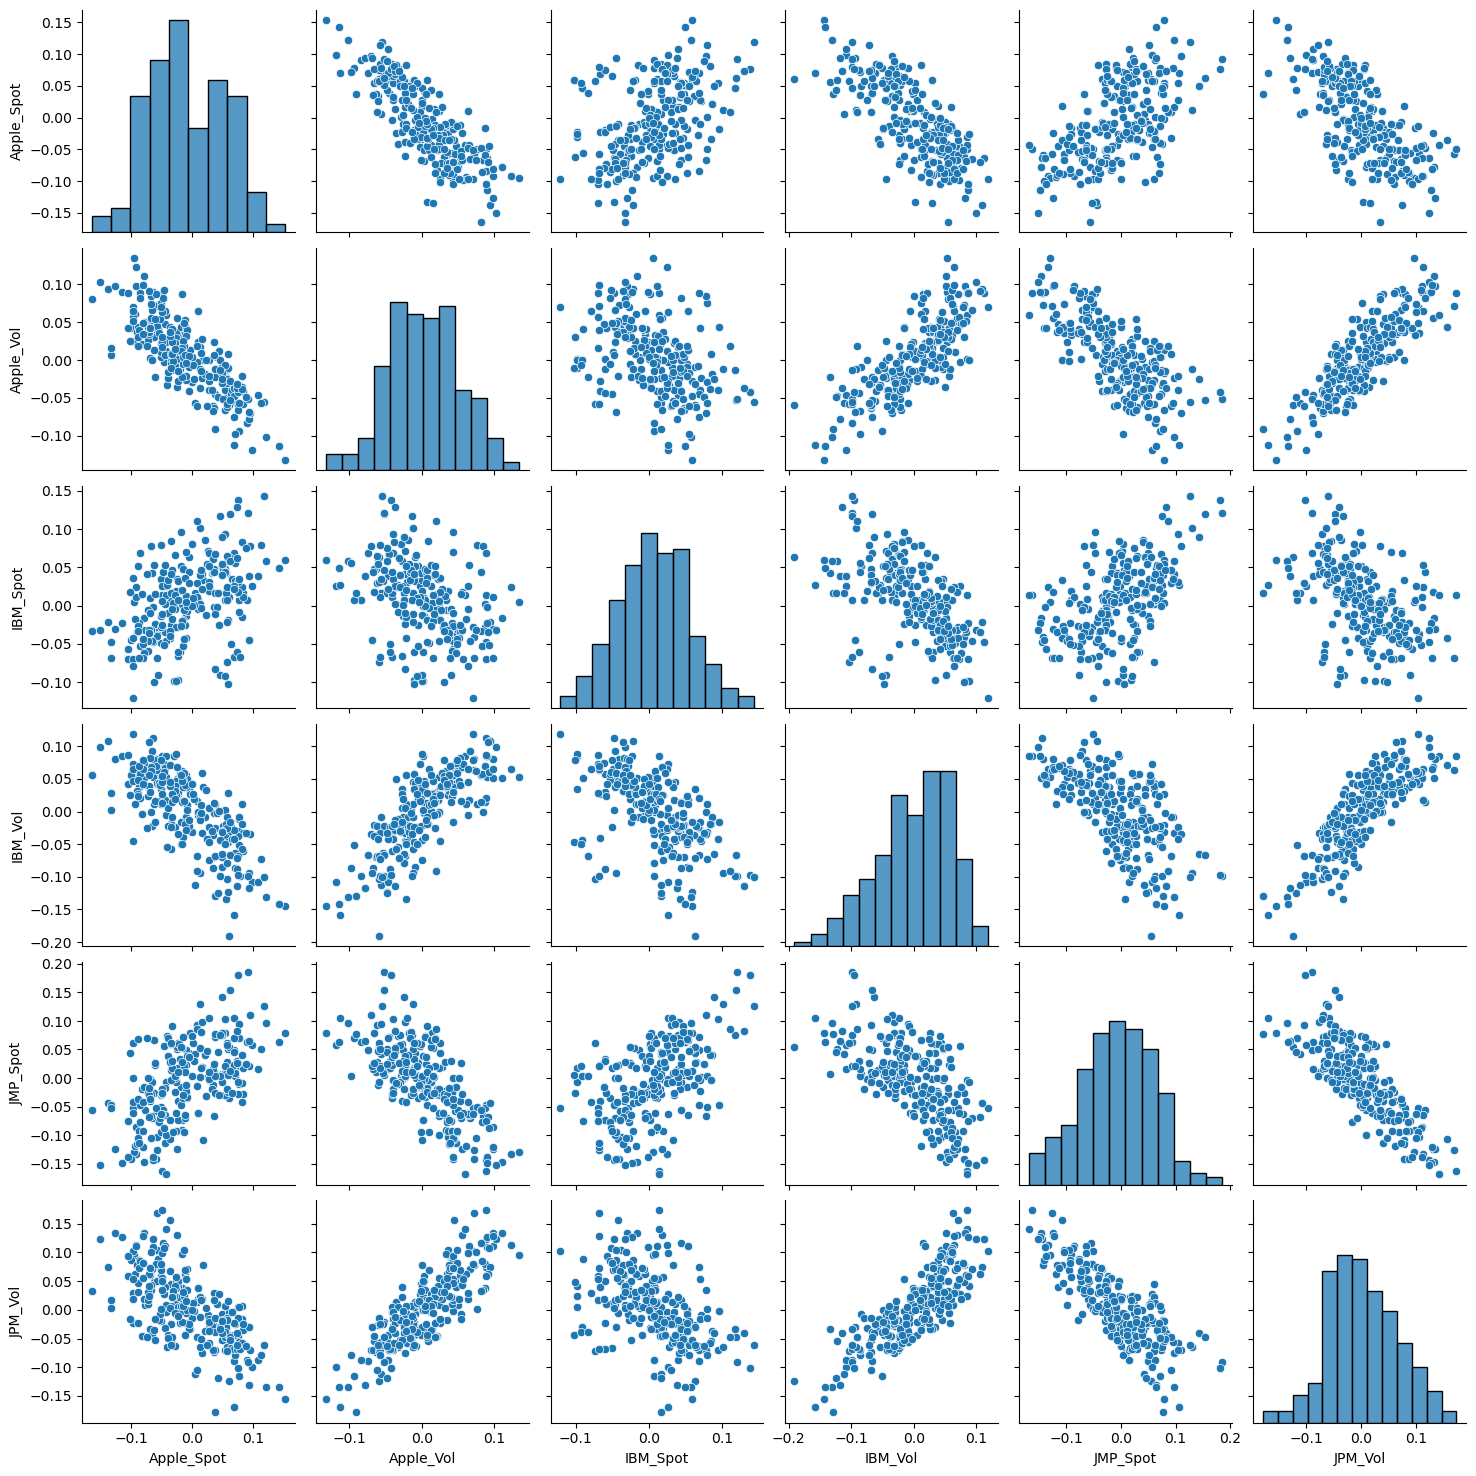

In [10]:
# sns.pairplot(hist_schocks_daily);
sns.pairplot(hist_schocks);


plt.savefig(PATH_FIGS + 'histdata_10d.pdf')

### Plot historical schocks. 1d / 10d

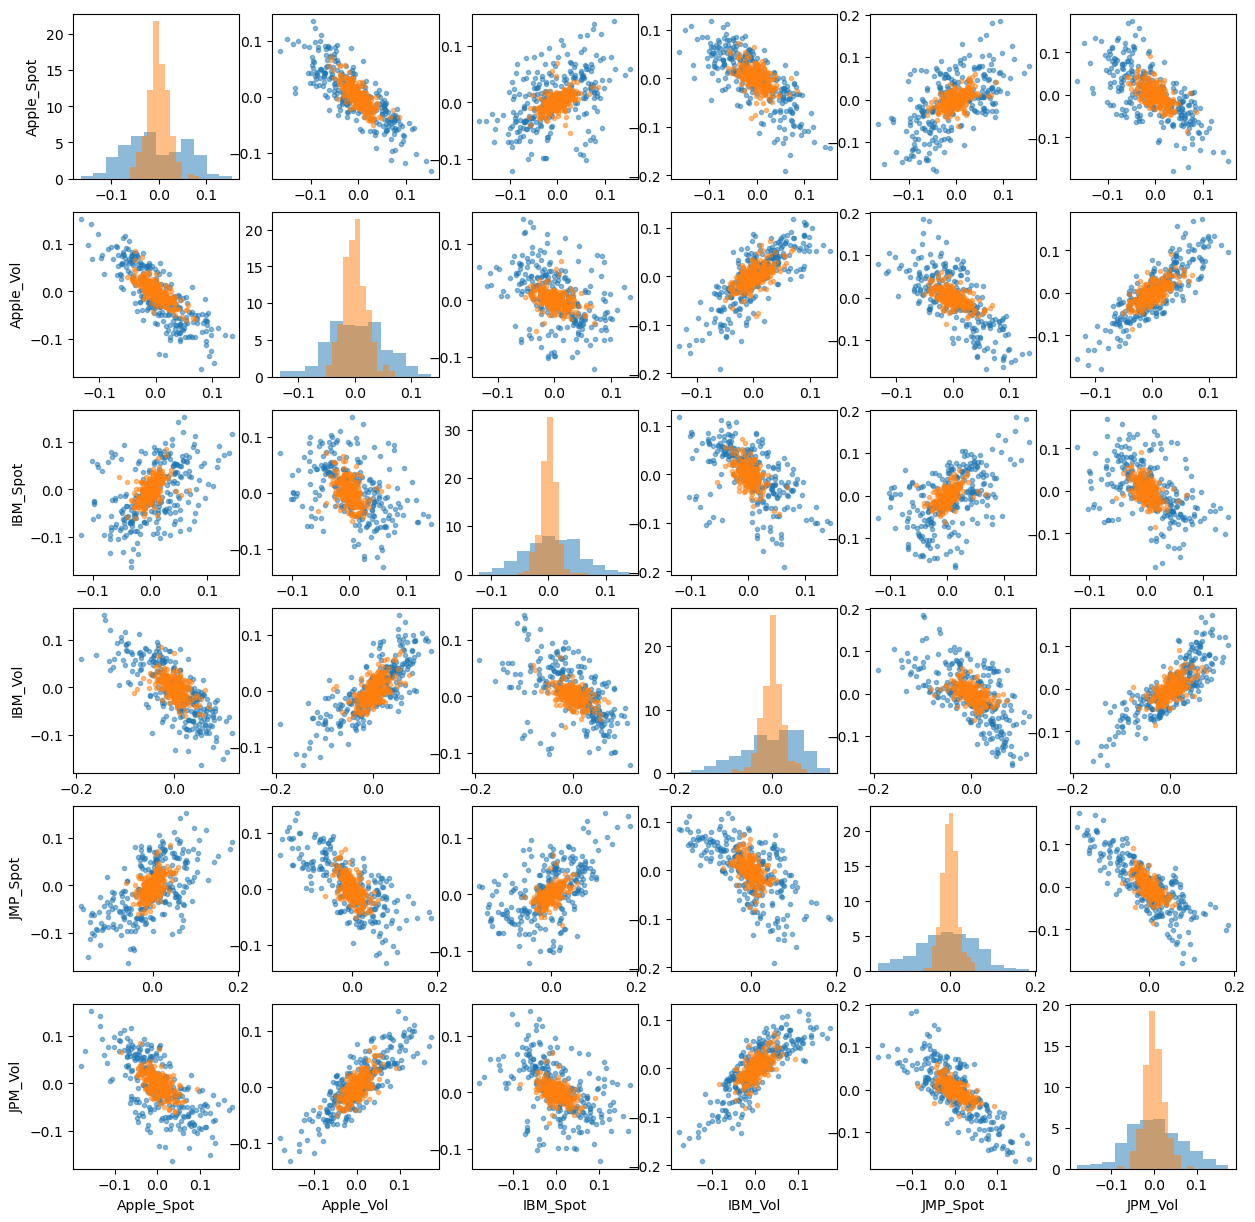

In [11]:
Miscellanea.plot_schocks(6,[hist_schocks.values,hist_schocks_daily.values],hist_schocks.columns,12)  

plt.savefig(PATH_FIGS + 'histdata_1d_10d.pdf')

### Fit a Gaussian Mixture to 10d data

In [12]:
from sklearn.mixture import GaussianMixture

GM = GaussianMixture(n_components= 6, random_state=1234)

GM.fit(hist_schocks)

GaussianMixture(n_components=6, random_state=1234)

### Plot synthetic data + real data

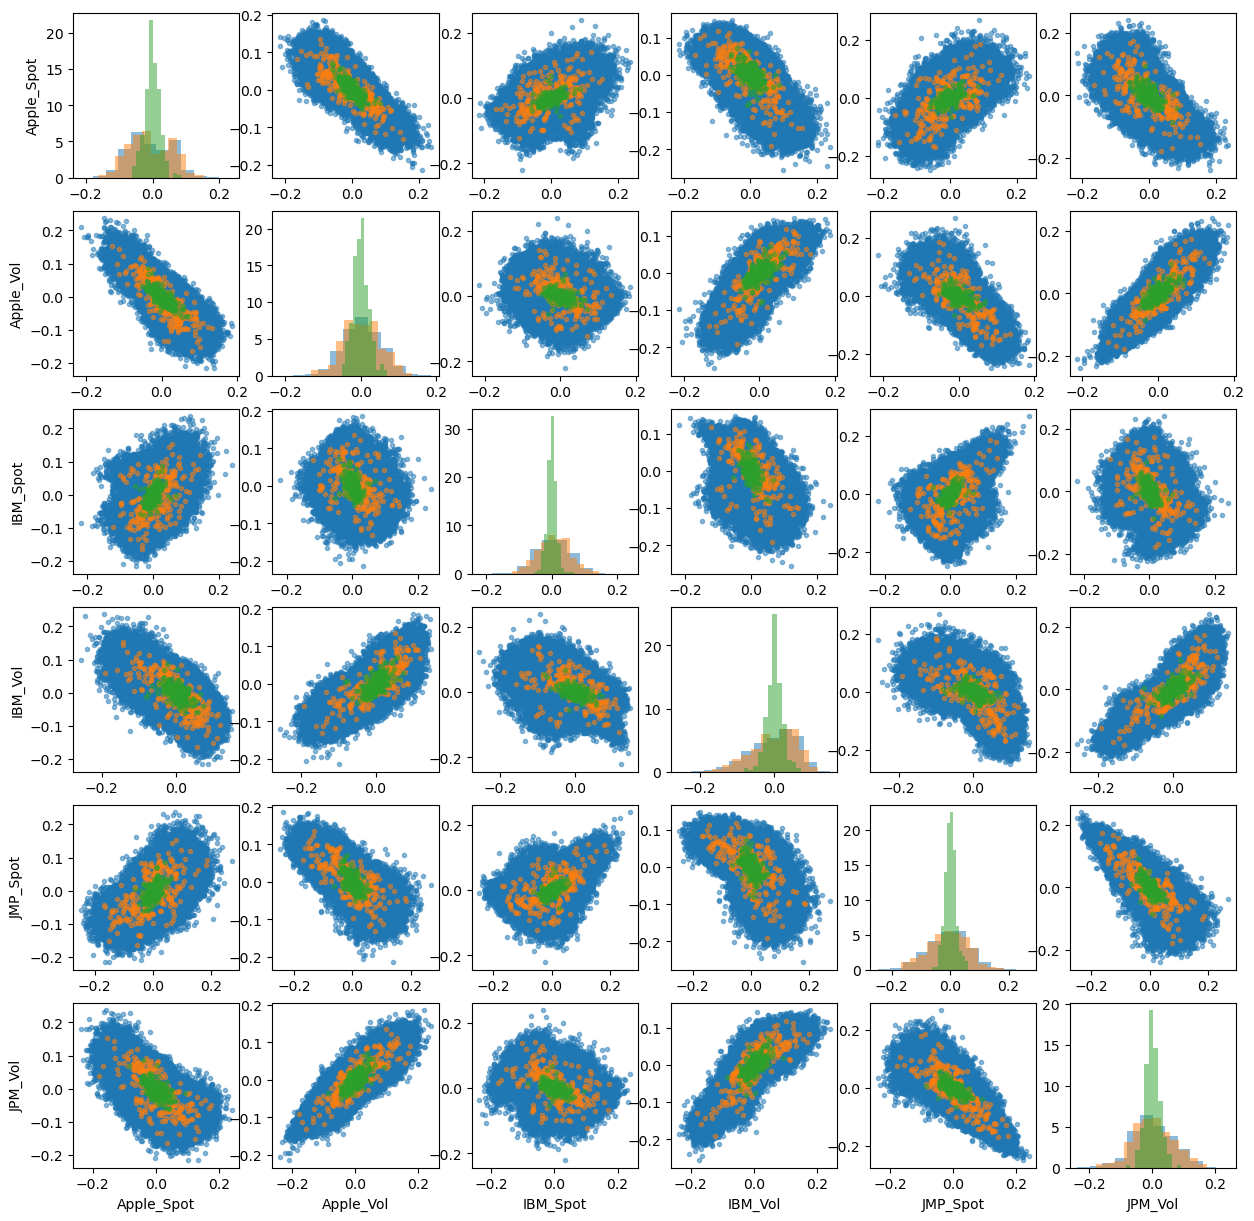

In [13]:
num_sims = 2**16 + 2**14

np.random.seed(5678)

sim_schocks = shuffle(GM.sample(num_sims)[0])

Miscellanea.plot_schocks(6,[sim_schocks,hist_schocks.values,hist_schocks_daily.values],hist_schocks.columns,12)     


### Simulate schocks from $t^+$ to $T$

In [14]:
np.random.seed(1234)


TTM = 3.0
rfr = 0.01  

S_A_0, S_B_0, S_C_0 = 1.0, 1.0, 1.0

vol_A, vol_B, vol_C  = 0.2, 0.3, 0.15

K_A, K_B, K_C = 1.0, 1.0, 1.0

K = 1.0

correlations = [[1.0, 0.6, 0.4],[0.6,1.0,0.7],[0.4,0.7,1.0]]

base_scenario = np.array([S_A_0, vol_A, S_B_0, vol_B, S_C_0, vol_C])

sim_scenarios = tf.constant(base_scenario * np.exp(sim_schocks))

hist_var_scenarios = base_scenario * np.exp(hist_schocks)

hist_var_scenarios_daily = base_scenario * np.exp(hist_schocks_daily)


chol = cholesky(correlations)

brow_ind =  np.sqrt(TTM) * np.random.normal(loc = 0.0, scale = 1.0, size = (num_sims, 3))

brow_correl = np.matmul(brow_ind, chol.T)


with tf.GradientTape() as tape:

  tape.watch(sim_scenarios)

  Spots_T = sim_scenarios[:,[0,2,4]]*tf.exp((rfr - 0.5 * sim_scenarios[:,[1,3,5]]**2)*TTM + sim_scenarios[:,[1,3,5]]* brow_correl)
  strikes = [K_A, K_B, K_C]
  payoff = tf.maximum(tf.exp(tf.reduce_mean(tf.math.log(Spots_T/strikes), axis = 1))-K,0)*tf.exp(-rfr * TTM)

  
sens = tape.gradient(payoff, sim_scenarios)



### <span style="color:red">-----------------Train Models (beware of the options)---------------.</span>

In [17]:
train_range = np.arange(0,2**16)
train_range_reduced = np.arange(0,2**14)
test_range = np.arange(2**16,num_sims)

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64, 128]
num_hidden_layers = [1, 2, 4]
# num_hidden_layers = [1]

# PATH_MODELS = 'MODELS/RED_SIMS_NO_EARLY/'
# PATH_MODELS = 'MODELS/EARLY/'
PATH_MODELS = 'MODELS/NO_EARLY/'
# PATH_MODELS = 'MODELS/RED_SIMS_EARLY/'



batch_size = 32

if (PATH_MODELS == 'MODELS/RED_SIMS_EARLY/') or (PATH_MODELS == 'MODELS/RED_SIMS_NO_EARLY/'):
    train_range_to_use = train_range_reduced
else:
    train_range_to_use = train_range

if (PATH_MODELS == 'MODELS/NO_EARLY/') or (PATH_MODELS == 'MODELS/RED_SIMS_NO_EARLY/'): 
    epochs = 20
    valid_data = None
else:
    
    epochs = 500
    valid_data = dict()
    valid_data['X_val'] = sim_scenarios.numpy()[test_range]
    valid_data['y_val'] = payoff.numpy()[test_range]
    valid_data['dydX_val'] = sens.numpy()[test_range]
    valid_data['patience'] = 5
    valid_data['start_from_epoch'] = 5

# PATH_MODELS = 'MODELS/ONE_NO_EARLY/'
    
ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,
              sim_scenarios.numpy()[train_range_to_use], payoff.numpy()[train_range_to_use],
              sens.numpy()[train_range_to_use], epochs, batch_size, valid_data)


### Compute closed form formulas for different scenarios (inc base with sensitivities)

In [15]:
train_range = np.arange(0,2**16)
train_range_reduced = np.arange(0,2**14)
test_range = np.arange(2**16,num_sims)


closed_form_sim_data = Option_formulas.BasketOptionVectorized(3, sim_scenarios[:,[0,2,4]].numpy(), [K_A, K_B, K_C],
                  K,
                  np.array([rfr, rfr, rfr]), rfr, [0.0, 0.0, 0.0], 
                  sim_scenarios[:,[1,3,5]].numpy(), np.array(correlations),
                  TTM, True).numpy() 

closed_form_daily = Option_formulas.BasketOptionVectorized(3, hist_var_scenarios_daily.values[:,[0,2,4]], [K_A, K_B, K_C],
                  K,
                  np.array([rfr, rfr, rfr]), rfr, [0.0, 0.0, 0.0], 
                  hist_var_scenarios_daily.values[:,[1,3,5]], np.array(correlations),
                  TTM, True).numpy() 

closed_form_10d = Option_formulas.BasketOptionVectorized(3, hist_var_scenarios.values[:,[0,2,4]], [K_A, K_B, K_C],
                  K,
                  np.array([rfr, rfr, rfr]), rfr, [0.0, 0.0, 0.0], 
                  hist_var_scenarios.values[:,[1,3,5]], np.array(correlations),
                  TTM, True).numpy() 


base_scenario_TF = tf.constant(base_scenario)

with tf.GradientTape() as tape:

    tape.watch(base_scenario_TF)

    closed_form_base = Option_formulas.BasketOptionVectorized(3, base_scenario_TF.reshape(1,-1)[:,[0,2,4]], [K_A, K_B, K_C],
                  K,
                  np.array([rfr, rfr, rfr]), rfr, [0.0, 0.0, 0.0], 
                  base_scenario_TF.reshape(1,-1)[:,[1,3,5]], np.array(correlations),
                  TTM, True)


sens_base = tape.gradient(closed_form_base, base_scenario_TF).numpy()

closed_form_base = closed_form_base.numpy()[0]

In [16]:
sens_base

array([0.1857298 , 0.14469301, 0.1857298 , 0.1384539 , 0.1857298 ,
       0.17255248])

### Compute bayes error

In [17]:
bayes_error_train = mean_squared_error(closed_form_sim_data[train_range], payoff.numpy()[train_range])
bayes_error_cv = mean_squared_error(closed_form_sim_data[test_range], payoff.numpy()[test_range])


print(bayes_error_train, bayes_error_cv)


0.05070487421768752 0.05115734419726224


### Load saved models

In [18]:
# PATH_MODELS = 'MODELS/RED_SIMS_NO_EARLY/'
# PATH_MODELS = 'MODELS/EARLY/'
PATH_MODELS = 'MODELS/NO_EARLY/'
# PATH_MODELS = 'MODELS/RED_SIMS_EARLY/'

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64, 128]
num_hidden_layers = [1, 2, 4]

models = ModelHandlers.load_models(PATH_MODELS, alphas, cells_layer, num_hidden_layers)



### Compute metrics

In [25]:
BASE_SCEN_CTRL_VAR = True


if (PATH_MODELS == 'MODELS/EARLY/') or (PATH_MODELS == 'MODELS/NO_EARLY/'):
    train_range_to_use = train_range
else:
    train_range_to_use = train_range_reduced


closed_formula_plus_adj_train = closed_form_sim_data[train_range_to_use] - closed_form_base
closed_formula_plus_adj_cv = closed_form_sim_data[test_range] - closed_form_base

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_cv = 0
    model_adj_test = 0
    adjust_model_with_base_scenario = "NPV"
#     adjust_model_with_base_scenario = "NPV_plus_sens"
    
else:
    model_adj_train = - closed_form_base
    model_adj_cv = - closed_form_base
    model_adj_test = - closed_form_base
    adjust_model_with_base_scenario = "No"



test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': base_scenario.reshape(1,-1), 
                        'base_scenario_closed_form_sens': sens_base}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': hist_var_scenarios_daily.values, 
                    'closed_formula_plus_adj': closed_form_daily - closed_form_base,
                     'model_adj': model_adj_test}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': hist_var_scenarios.values, 
                    'closed_formula_plus_adj': closed_form_10d - closed_form_base,
                   'model_adj': model_adj_test}]

metrics, best_model_params = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers, 
                    sim_scenarios[train_range_to_use], payoff[train_range_to_use], sim_scenarios[test_range], payoff[test_range], 
                    closed_formula_plus_adj_train, closed_formula_plus_adj_cv, model_adj_train, model_adj_cv,
                    test_scenarios_data, adjust_model_with_base_scenario)




Best model:
{'model_name': 'alpha_0.1_cells_64_hidden_2', 'model_params': {'alpha': 0.1, 'cells': 64, 'hidden': 2}, 'mse_train': 0.05071229468419567, 'mse_cv': 0.05116179670661813, 'spearman_train': 0.9995876981287102, 'spearman_cv': 0.9996009453592392, 'ks_train': 0.038665771484375, 'ks_cv': 0.04180908203125, 'spearman_1d': 0.998525322969631, 'ks_1d': 0.064, 'spearman_10d': 0.9994662310497622, 'ks_10d': 0.056}


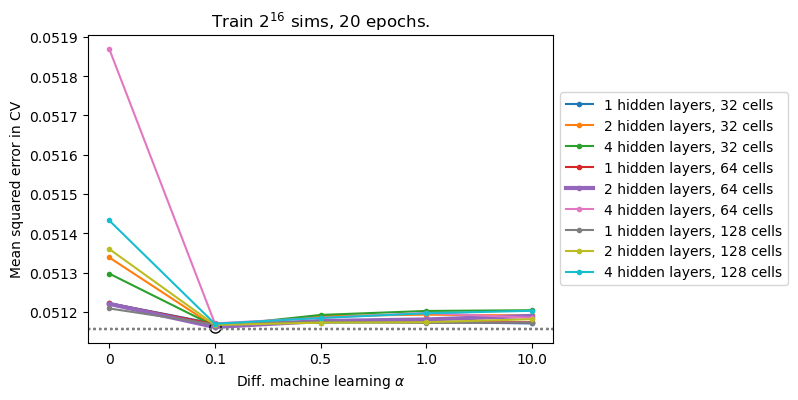

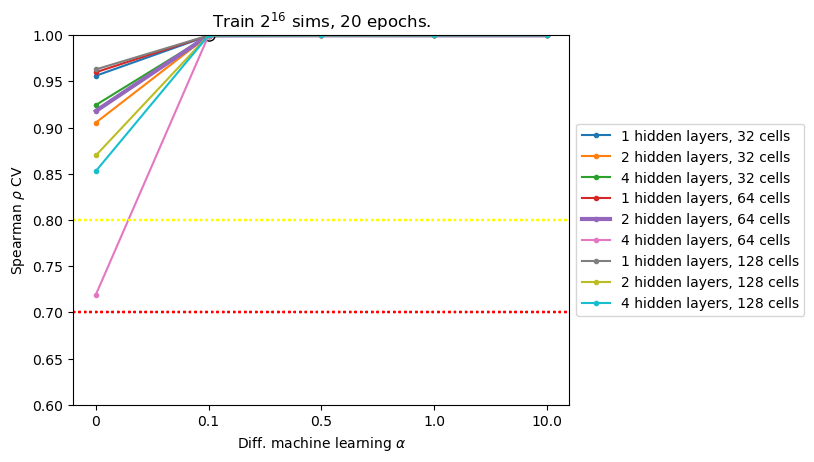

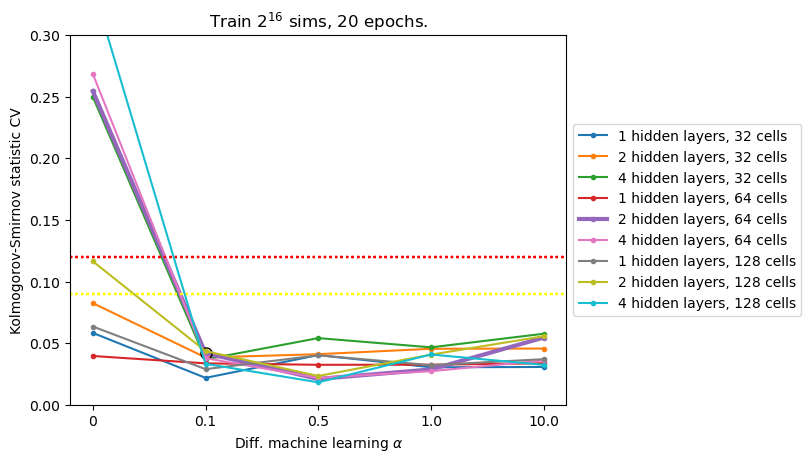

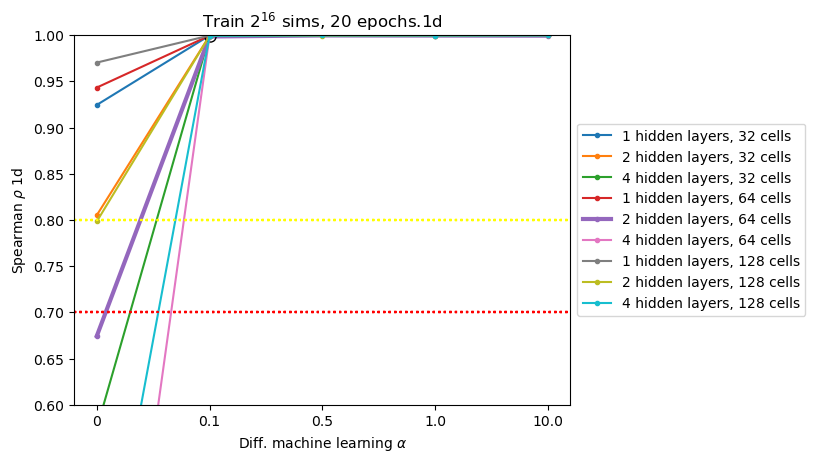

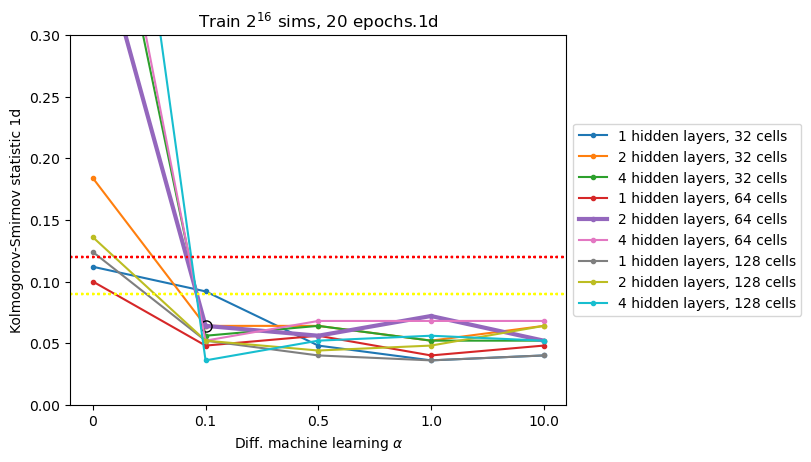

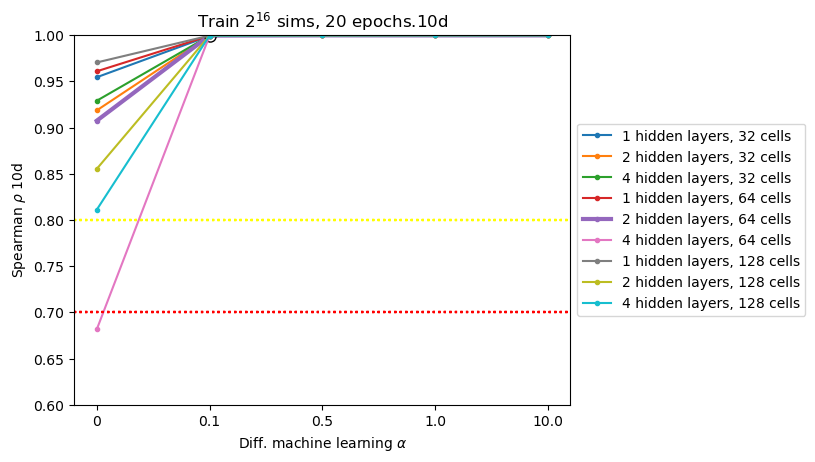

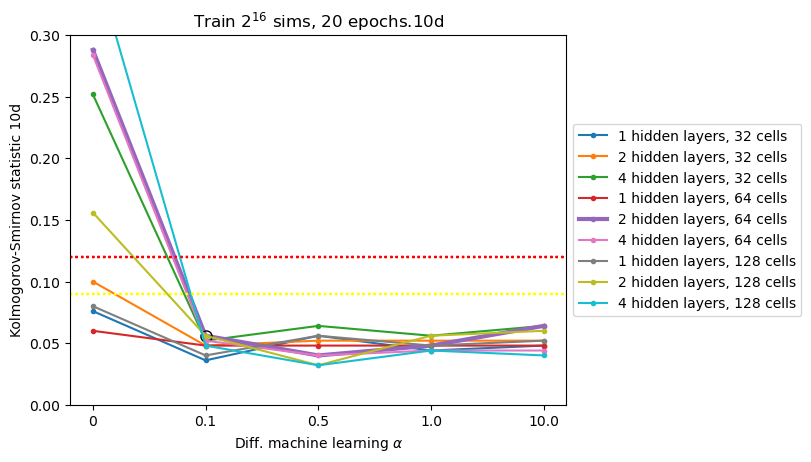

<Figure size 640x480 with 0 Axes>

In [26]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios_data][1:] 

if PATH_MODELS == 'MODELS/RED_SIMS_NO_EARLY/':
    chart_name = r'Train $2^{14}$ sims, 20 epochs.'
    file_name = 'Reduced_No_Early_'
elif PATH_MODELS == 'MODELS/EARLY/':
    chart_name = r'Train $2^{16}$ sims, early stopping.'
    file_name = 'Full_Early_'
elif PATH_MODELS == 'MODELS/NO_EARLY/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Full_No_Early_'
elif PATH_MODELS == 'MODELS/RED_SIMS_EARLY/':
    chart_name = r'Train $2^{14}$ sims, early stopping.'
    file_name = 'Reduced_Early_'

file_name = "CV_" + file_name 
    
ModelHandlers.plot_model_results(metrics, best_model_params,alphas, cells_layer, num_hidden_layers, test_scenario_names, 
                                 bayes_error_cv, file_name, chart_name, "",PATH_FIGS)

### Basket calcs

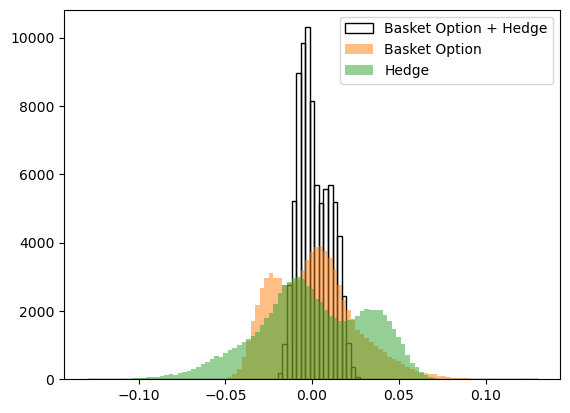

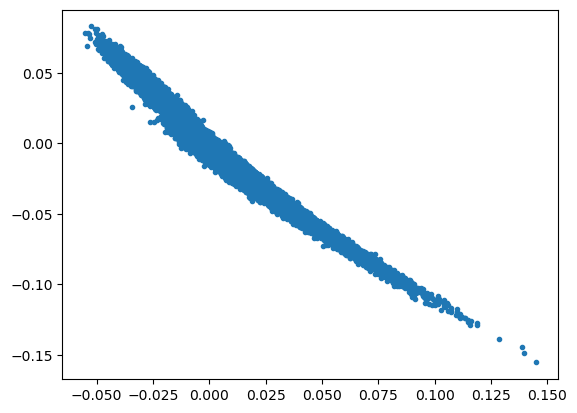

In [41]:
TTM_Hedge = 3.0


call_A = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,0], K_A, TTM_Hedge, rfr, 0.0, MktData[:,1], True)
Fut_A = lambda MktData: Option_formulas.FutureTF(MktData[:,0], K_A, TTM_Hedge, rfr, 0.0)

call_B = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,2], K_B, TTM, rfr, 0.0, MktData[:,3], True)
Fut_B = lambda MktData: Option_formulas.FutureTF(MktData[:,2], K_B, TTM_Hedge, rfr, 0.0)

call_C = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,4], K_C, TTM_Hedge, rfr, 0.0, MktData[:,5], True)
Fut_C = lambda MktData: Option_formulas.FutureTF(MktData[:,4], K_C, TTM_Hedge, rfr, 0.0)

exot = lambda MktData: Option_formulas.BasketOptionVectorized(3, MktData[:,[0,2,4]], [K_A, K_B, K_C],
                  K,
                  np.array([rfr, rfr, rfr]), rfr, [0.0, 0.0, 0.0], 
                  MktData[:,[1,3,5]], np.array(correlations),
                  TTM, True) 

basket_elements = [Fut_A, call_A, Fut_B, call_B, Fut_C, call_C]

my_basket = Option_formulas.Basket(basket_elements, exot)

my_basket.compute_hedge(base_scenario)


bins = np.linspace(-0.13,0.13,100)

plt.hist((exot(sim_scenarios).numpy()-exot(base_scenario.reshape(1,-1)).numpy())
         +(my_basket.value_basket(sim_scenarios)-my_basket.value_basket(base_scenario)), bins = bins, alpha = 1.0, facecolor = 'None',
         edgecolor= 'black',label = 'Basket Option + Hedge');

plt.hist(exot(sim_scenarios).numpy()-exot(base_scenario.reshape(1,-1)).numpy(), bins = bins, alpha = 0.5, label = "Basket Option")

plt.hist(my_basket.value_basket(sim_scenarios)-my_basket.value_basket(base_scenario), bins=bins, alpha = 0.5, label = 'Hedge');


plt.legend()
plt.savefig(PATH_FIGS + 'hedge_histogram.pdf')
plt.figure()



plt.plot(exot(sim_scenarios).numpy()-exot(base_scenario.reshape(1,-1)).numpy(), my_basket.value_basket(sim_scenarios)-my_basket.value_basket(base_scenario), '.')

In [42]:
basket_base = my_basket.value_basket(base_scenario)

basket_sim_data_PL_inc = my_basket.value_basket(sim_scenarios) - basket_base

basket_daily_PL_inc = my_basket.value_basket(hist_var_scenarios_daily.values) - basket_base

basket_10d_PL_inc = my_basket.value_basket(hist_var_scenarios.values) - basket_base


### Compute metrics with hedge basket

In [45]:
BASE_SCEN_CTRL_VAR = True


if (PATH_MODELS == 'MODELS/EARLY/') or (PATH_MODELS == 'MODELS/NO_EARLY/'):
    train_range_to_use = train_range
else:
    train_range_to_use = train_range_reduced


closed_formula_plus_adj_train = closed_form_sim_data[train_range_to_use] - closed_form_base + \
    basket_sim_data_PL_inc[train_range_to_use]
closed_formula_plus_adj_cv = closed_form_sim_data[test_range] - closed_form_base + \
    basket_sim_data_PL_inc[test_range]

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_cv = 0
    model_adj_test = 0
    adjust_model_with_base_scenario = 'NPV'
else:
    model_adj_train = - closed_form_base
    model_adj_cv = - closed_form_base
    model_adj_test = - closed_form_base
    adjust_model_with_base_scenario = 'No'


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': base_scenario.reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': hist_var_scenarios_daily, 
                    'closed_formula_plus_adj': closed_form_daily - closed_form_base + basket_daily_PL_inc,
                     'model_adj': model_adj_test + basket_daily_PL_inc}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': hist_var_scenarios, 
                    'closed_formula_plus_adj': closed_form_10d - closed_form_base + basket_10d_PL_inc,
                   'model_adj': model_adj_test + basket_10d_PL_inc}]

metrics, best_model_metrics = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers, 
                    sim_scenarios[train_range_to_use], payoff[train_range_to_use], sim_scenarios[test_range], payoff[test_range], 
                    closed_formula_plus_adj_train, closed_formula_plus_adj_cv,
                    model_adj_train + basket_sim_data_PL_inc[train_range_to_use],
                    model_adj_cv + basket_sim_data_PL_inc[test_range],
                    test_scenarios_data, adjust_model_with_base_scenario)




Best model:
{'model_name': 'alpha_0.1_cells_64_hidden_2', 'model_params': {'alpha': 0.1, 'cells': 64, 'hidden': 2}, 'mse_train': 0.05071229468419567, 'mse_cv': 0.05116179670661813, 'spearman_train': 0.9968970122347706, 'spearman_cv': 0.9968830209220257, 'ks_train': 0.0641326904296875, 'ks_cv': 0.06597900390625, 'spearman_1d': 0.9662598503817266, 'ks_1d': 0.116, 'spearman_10d': 0.9967075287918427, 'ks_10d': 0.088}


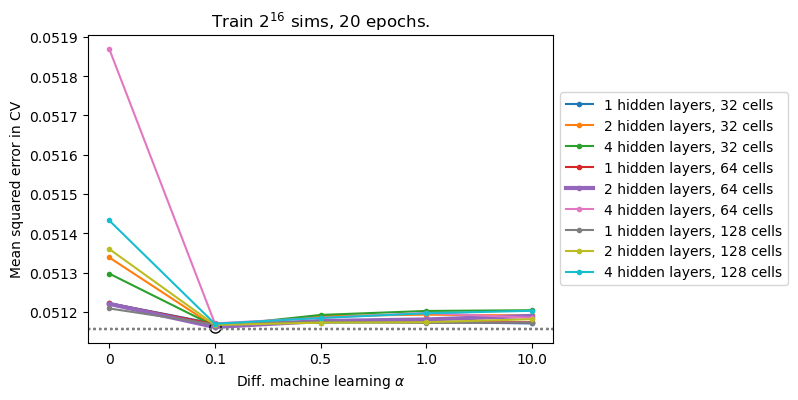

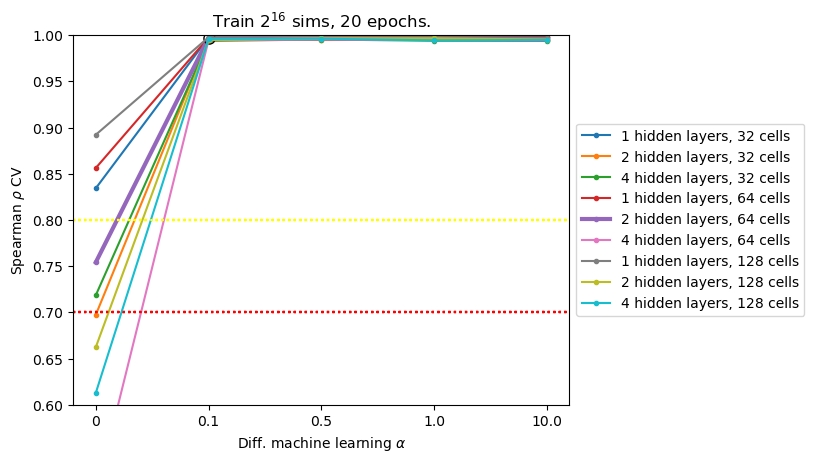

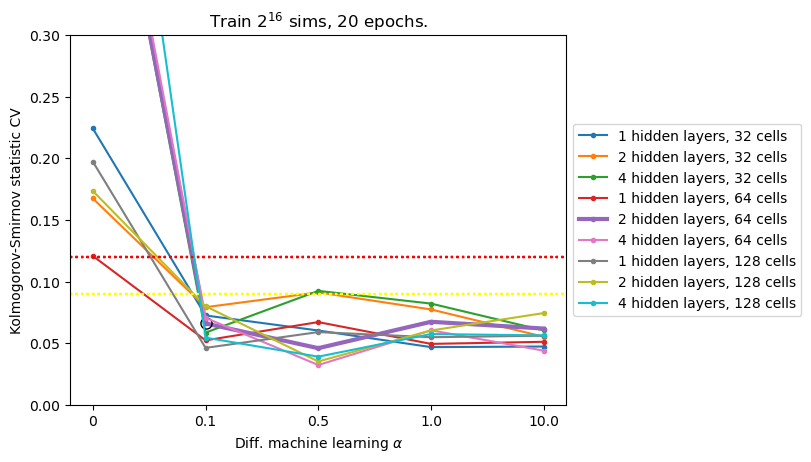

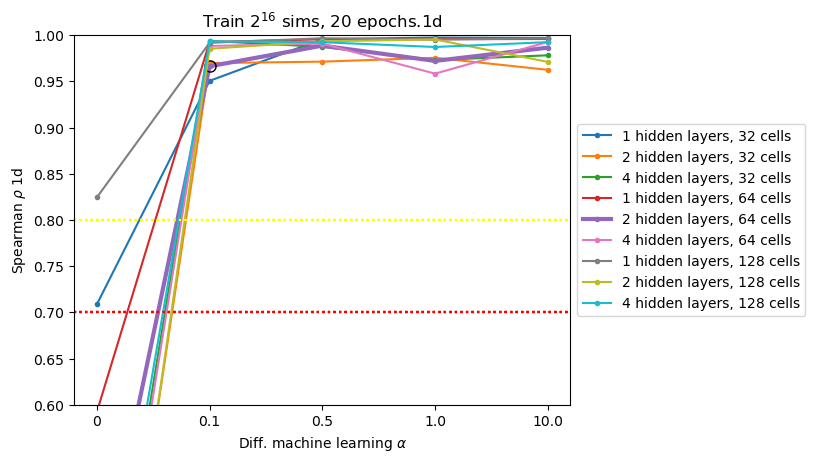

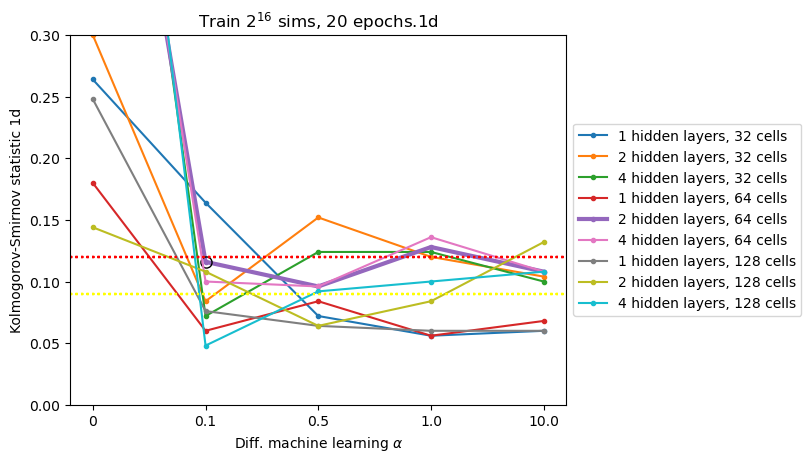

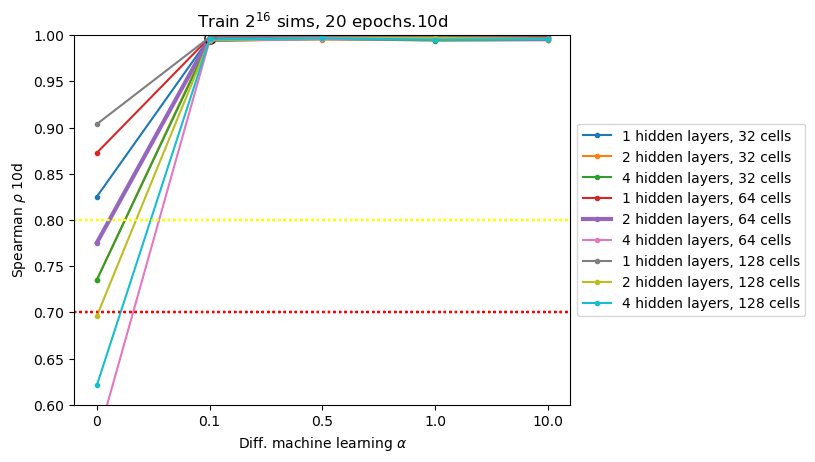

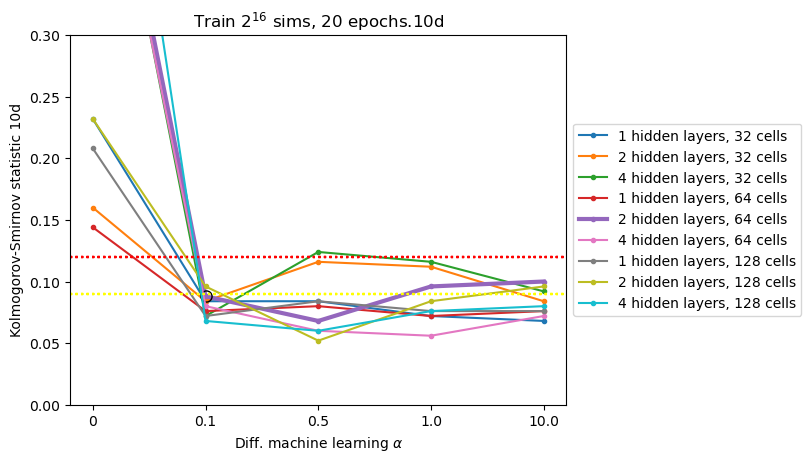

<Figure size 640x480 with 0 Axes>

In [46]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios_data][1:] 

if PATH_MODELS == 'MODELS/RED_SIMS_NO_EARLY/':
    chart_name = r'Train $2^{14}$ sims, 20 epochs.'
    file_name = 'Reduced_No_Early_'
elif PATH_MODELS == 'MODELS/EARLY/':
    chart_name = r'Train $2^{16}$ sims, early stopping.'
    file_name = 'Full_Early_'
elif PATH_MODELS == 'MODELS/NO_EARLY/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Full_No_Early_'
elif PATH_MODELS == 'MODELS/RED_SIMS_EARLY/':
    chart_name = r'Train $2^{14}$ sims, early stopping.'
    file_name = 'Reduced_Early_'

file_name = 'Hedge_' + file_name 
    
ModelHandlers.plot_model_results(metrics, best_model_metrics,alphas, cells_layer, num_hidden_layers, test_scenario_names, 
                                 bayes_error_cv, file_name, chart_name, "",PATH_FIGS)

### Simulation of scenarios computing variance reduction

In [47]:
np.random.seed(1234)


TTM = 3.0
rfr = 0.01  

S_A_0, S_B_0, S_C_0 = 1.0, 1.0, 1.0

vol_A, vol_B, vol_C  = 0.2, 0.3, 0.15

K_A, K_B, K_C = 1.0, 1.0, 1.0

K = 1.0

correlations = [[1.0, 0.6, 0.4],[0.6,1.0,0.7],[0.4,0.7,1.0]]

base_scenario = np.array([S_A_0, vol_A, S_B_0, vol_B, S_C_0, vol_C])

sim_scenarios = tf.constant(base_scenario * np.exp(sim_schocks))

base_scenario = base_scenario.reshape(1,-1)

chol = cholesky(correlations)

brow_ind =  np.sqrt(TTM) * np.random.normal(loc = 0.0, scale = 1.0, size = (num_sims, 3))

brow_correl = np.matmul(brow_ind, chol.T)


with tf.GradientTape(persistent=True) as tape:

    tape.watch(sim_scenarios)
#     tape.watch(base_scenario)


    Spots_T_pert = sim_scenarios[:,[0,2,4]]*tf.exp((rfr - 0.5 * sim_scenarios[:,[1,3,5]]**2)*TTM + sim_scenarios[:,[1,3,5]]* brow_correl)

    Spots_T_base = base_scenario[:,[0,2,4]]*tf.exp((rfr - 0.5 * base_scenario[:,[1,3,5]]**2)*TTM + base_scenario[:,[1,3,5]]* brow_correl)

   
    strikes = [K_A, K_B, K_C]
    payoff_pert = tf.maximum(tf.exp(tf.reduce_mean(tf.math.log(Spots_T_pert/strikes), axis = 1))-K,0)*tf.exp(-rfr * TTM)
    payoff_base = tf.maximum(tf.exp(tf.reduce_mean(tf.math.log(Spots_T_base/strikes), axis = 1))-K,0)*tf.exp(-rfr * TTM)
    
    delta_payoff = payoff_pert - payoff_base  
    
    
sens_var_red = tape.gradient(delta_payoff, sim_scenarios)
# sens_base = tape.gradient(payoff_base, base_scenario)

# sens_vr = sens_pert - sens_base  


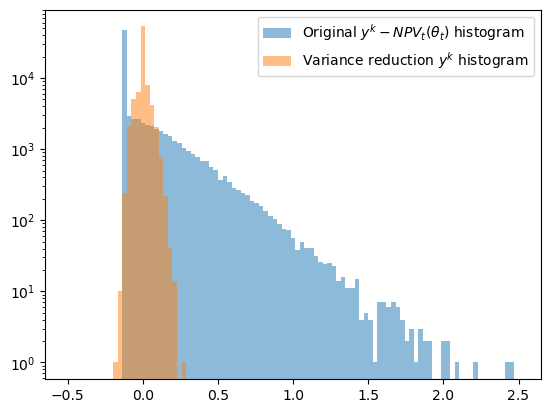

In [57]:
bins = np.linspace(-0.5,2.5,100)
plt.hist((payoff-closed_form_base).numpy(), bins = bins, alpha = 0.5, 
         label = r'Original $y^k-NPV_t\left(\theta_t\right)$ histogram')
plt.hist(delta_payoff.numpy(), bins = bins, alpha = 0.5, label = r'Variance reduction $y^k$ histogram')

plt.yscale('log')

plt.legend()

plt.savefig(PATH_FIGS + 'y_histogram.pdf')

### <span style="color:red">-----------------Train Models VR (beware of the options)---------------.</span>

In [41]:
train_range = np.arange(0,2**16)
train_range_reduced = np.arange(0,2**14)
test_range = np.arange(2**16,num_sims)

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64, 128]
# num_hidden_layers = [1, 2, 4]
num_hidden_layers = [1]


# PATH_MODELS = 'MODELS_VR/RED_SIMS_NO_EARLY/'
# PATH_MODELS = 'MODELS_VR/EARLY/'
PATH_MODELS = 'MODELS_VR/NO_EARLY/'
# PATH_MODELS = 'MODELS_VR/RED_SIMS_EARLY/'

batch_size = 32

if (PATH_MODELS == 'MODELS_VR/RED_SIMS_EARLY/') or (PATH_MODELS == 'MODELS_VR/RED_SIMS_NO_EARLY/'):
    train_range_to_use = train_range_reduced
else:
    train_range_to_use = train_range

if (PATH_MODELS == 'MODELS_VR/NO_EARLY/') or (PATH_MODELS == 'MODELS_VR/RED_SIMS_NO_EARLY/'): 
    epochs = 20
    valid_data = None
else:
    
    epochs = 500
    valid_data = dict()
    valid_data['X_val'] = sim_scenarios.numpy()[test_range]
    valid_data['y_val'] = payoff.numpy()[test_range]
    valid_data['dydX_val'] = sens.numpy()[test_range]
    valid_data['patience'] = 5
    valid_data['start_from_epoch'] = 5


PATH_MODELS = 'MODELS_VR/ONE_NO_EARLY/'

ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,
              sim_scenarios.numpy()[train_range_to_use], delta_payoff.numpy()[train_range_to_use],
              sens_var_red.numpy()[train_range_to_use], epochs, batch_size, valid_data)


### Load models data for variance reduction

In [58]:
# PATH_MODELS = 'MODELS_VR/RED_SIMS_NO_EARLY/'
# PATH_MODELS = 'MODELS_VR/EARLY/'
PATH_MODELS = 'MODELS_VR/NO_EARLY/'
# PATH_MODELS = 'MODELS_VR/RED_SIMS_EARLY/'

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64, 128]
num_hidden_layers = [1, 2, 4]

models = ModelHandlers.load_models(PATH_MODELS, alphas, cells_layer, num_hidden_layers)


### Compute metrics (no hedge)

In [61]:
BASE_SCEN_CTRL_VAR = True


if (PATH_MODELS == 'MODELS_VR/EARLY/') or (PATH_MODELS == 'MODELS_VR/NO_EARLY/'):
    train_range_to_use = train_range
else:
    train_range_to_use = train_range_reduced


closed_formula_plus_adj_train = closed_form_sim_data[train_range_to_use] - closed_form_base 
closed_formula_plus_adj_cv = closed_form_sim_data[test_range] - closed_form_base 

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_cv = 0
    model_adj_test = 0
    adjust_model_with_base_scenario = 'NPV'
else:
    model_adj_train = - closed_form_base
    model_adj_cv = - closed_form_base
    model_adj_test = - closed_form_base
    adjust_model_with_base_scenario = 'No'


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': base_scenario.reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': hist_var_scenarios_daily, 
                    'closed_formula_plus_adj': closed_form_daily - closed_form_base,
                     'model_adj': model_adj_test}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': hist_var_scenarios, 
                    'closed_formula_plus_adj': closed_form_10d - closed_form_base,
                   'model_adj': model_adj_test}]

metrics, best_model_metrics = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers, 
                    sim_scenarios[train_range_to_use], payoff[train_range_to_use], sim_scenarios[test_range], payoff[test_range], 
                    closed_formula_plus_adj_train, closed_formula_plus_adj_cv,
                    model_adj_train ,
                    model_adj_cv,
                    test_scenarios_data, adjust_model_with_base_scenario)




Best model:
{'model_name': 'alpha_0.1_cells_128_hidden_4', 'model_params': {'alpha': 0.1, 'cells': 128, 'hidden': 4}, 'mse_train': 0.0669518909964879, 'mse_cv': 0.06719447924054639, 'spearman_train': 0.9995655781898857, 'spearman_cv': 0.9995764043171811, 'ks_train': 0.023681640625, 'ks_cv': 0.02557373046875, 'spearman_1d': 0.999338699519194, 'ks_1d': 0.044, 'spearman_10d': 0.9994024859808848, 'ks_10d': 0.048}


# Plot charts (no hedge)

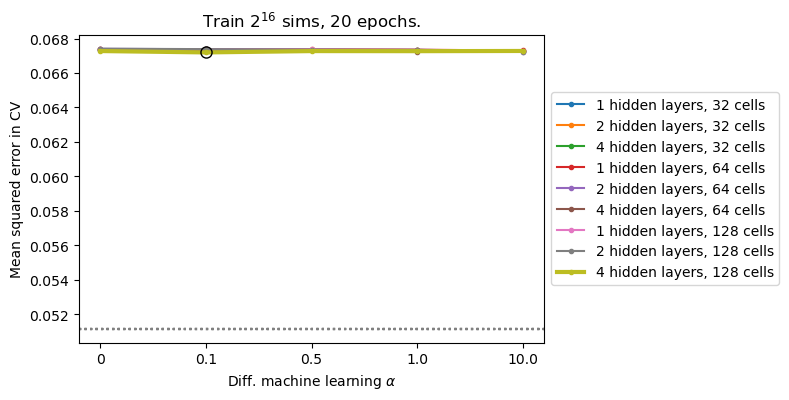

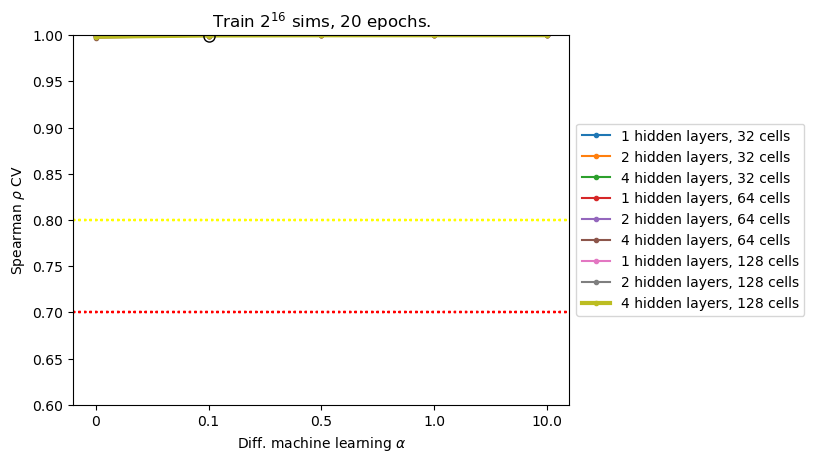

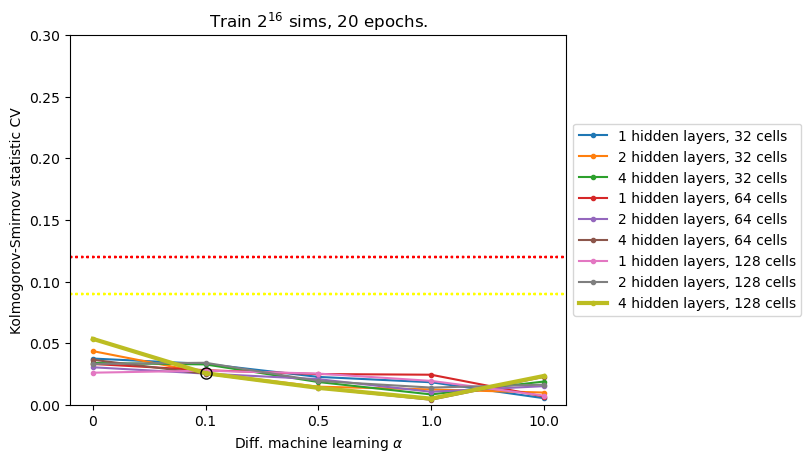

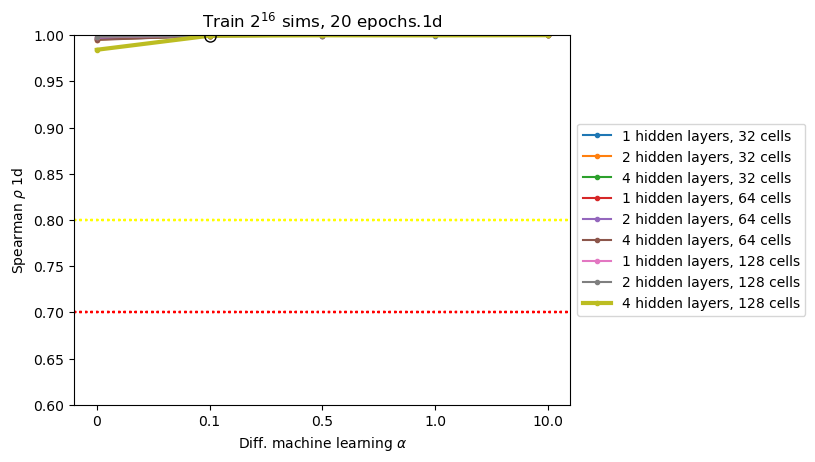

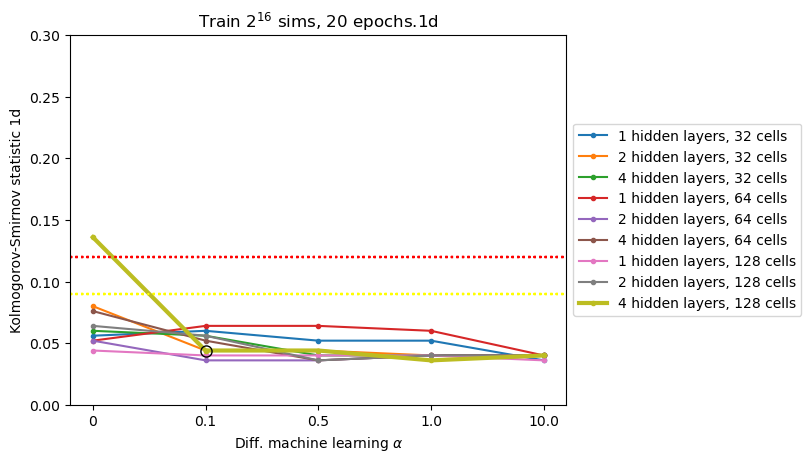

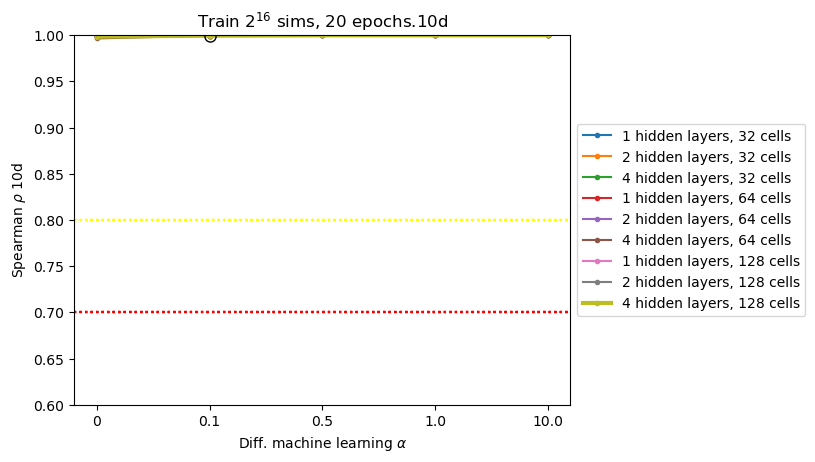

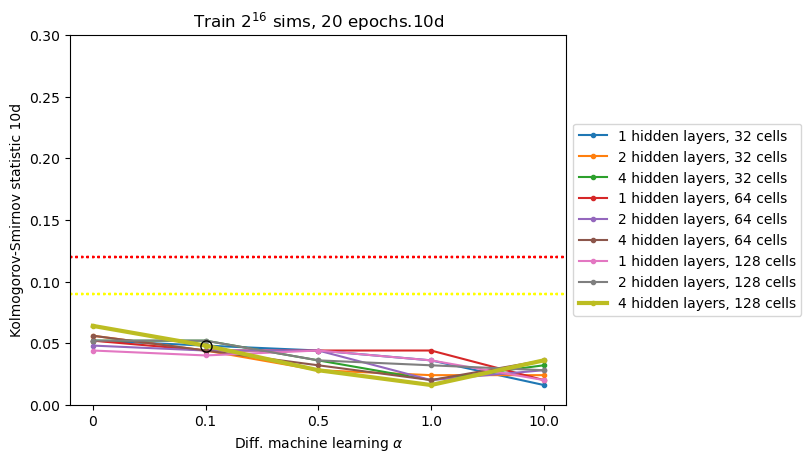

<Figure size 640x480 with 0 Axes>

In [63]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios_data][1:] 

if PATH_MODELS == 'MODELS_VR/RED_SIMS_NO_EARLY/':
    chart_name = r'Train $2^{14}$ sims, 20 epochs.'
    file_name = 'Reduced_No_Early_'
elif PATH_MODELS == 'MODELS_VR/EARLY/':
    chart_name = r'Train $2^{16}$ sims, early stopping.'
    file_name = 'Full_Early_'
elif PATH_MODELS == 'MODELS_VR/NO_EARLY/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Full_No_Early_'
elif PATH_MODELS == 'MODELS_VR/RED_SIMS_EARLY/':
    chart_name = r'Train $2^{14}$ sims, early stopping.'
    file_name = 'Reduced_Early_'

file_name = 'VR_' + file_name  
    
ModelHandlers.plot_model_results(metrics,best_model_metrics ,alphas, cells_layer, num_hidden_layers, test_scenario_names, 
                                 bayes_error_cv, file_name, chart_name, "",PATH_FIGS)

### Compute metrics (hedge)

In [65]:
BASE_SCEN_CTRL_VAR = True


if (PATH_MODELS == 'MODELS_VR/EARLY/') or (PATH_MODELS == 'MODELS_VR/NO_EARLY/'):
    train_range_to_use = train_range
else:
    train_range_to_use = train_range_reduced


closed_formula_plus_adj_train = closed_form_sim_data[train_range_to_use] - closed_form_base + \
    basket_sim_data_PL_inc[train_range_to_use]
closed_formula_plus_adj_cv = closed_form_sim_data[test_range] - closed_form_base + \
    basket_sim_data_PL_inc[test_range]

if BASE_SCEN_CTRL_VAR:
    model_adj_train = 0
    model_adj_cv = 0
    model_adj_test = 0
    adjust_model_with_base_scenario = 'NPV'
#     adjust_model_with_base_scenario = 'NPV_plus_sens'
else:
    model_adj_train = - closed_form_base
    model_adj_cv = - closed_form_base
    model_adj_test = - closed_form_base
    adjust_model_with_base_scenario = 'No'


test_scenarios_data = []

test_scenarios_data += [{'scenario_name': 'base', 'scenario': base_scenario.reshape(1,-1),
                        'base_scenario_closed_form_sens': sens_base}]
test_scenarios_data += [{'scenario_name': '1d', 'scenario': hist_var_scenarios_daily.values, 
                    'closed_formula_plus_adj': closed_form_daily - closed_form_base + basket_daily_PL_inc,
                     'model_adj': model_adj_test + basket_daily_PL_inc}]
test_scenarios_data += [{'scenario_name': '10d', 'scenario': hist_var_scenarios.values, 
                    'closed_formula_plus_adj': closed_form_10d - closed_form_base + basket_10d_PL_inc,
                   'model_adj': model_adj_test + basket_10d_PL_inc}]

metrics, best_model_metrics = ModelHandlers.compute_model_metrics(models, alphas, cells_layer, num_hidden_layers, 
                    sim_scenarios[train_range_to_use], payoff[train_range_to_use], sim_scenarios[test_range], payoff[test_range], 
                    closed_formula_plus_adj_train, closed_formula_plus_adj_cv,
                    model_adj_train + basket_sim_data_PL_inc[train_range_to_use],
                    model_adj_cv + basket_sim_data_PL_inc[test_range],
                    test_scenarios_data, adjust_model_with_base_scenario)




Best model:
{'model_name': 'alpha_0.1_cells_128_hidden_4', 'model_params': {'alpha': 0.1, 'cells': 128, 'hidden': 4}, 'mse_train': 0.0669518909964879, 'mse_cv': 0.06719447924054639, 'spearman_train': 0.996578415054059, 'spearman_cv': 0.9965386778556625, 'ks_train': 0.046478271484375, 'ks_cv': 0.0496826171875, 'spearman_1d': 0.9961589271724607, 'ks_1d': 0.084, 'spearman_10d': 0.9972743222958361, 'ks_10d': 0.064}


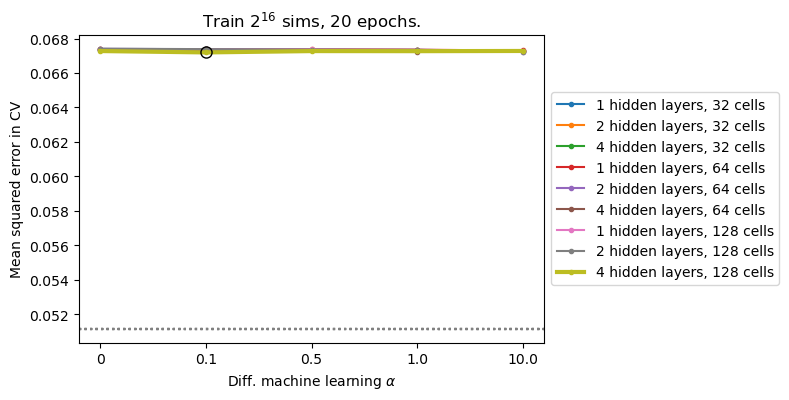

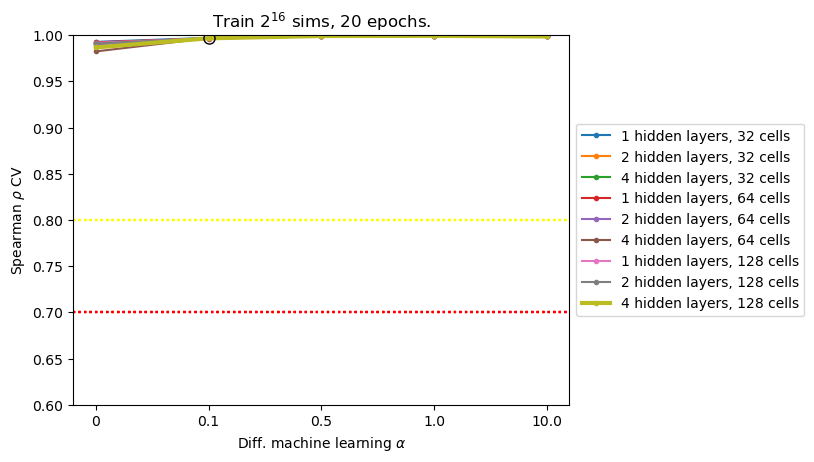

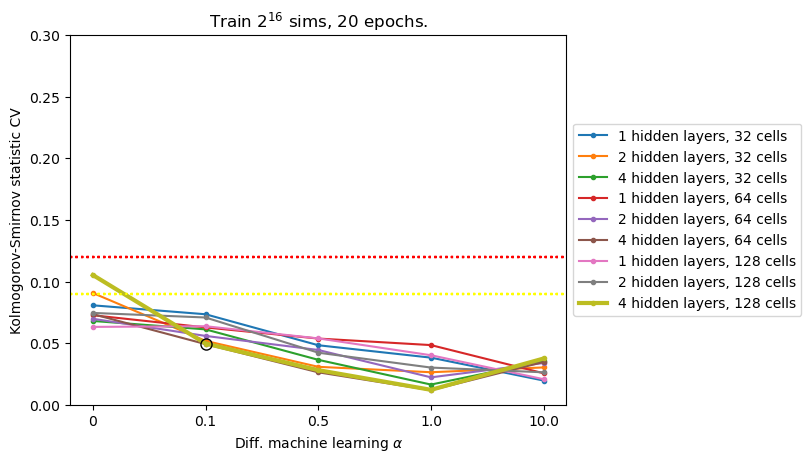

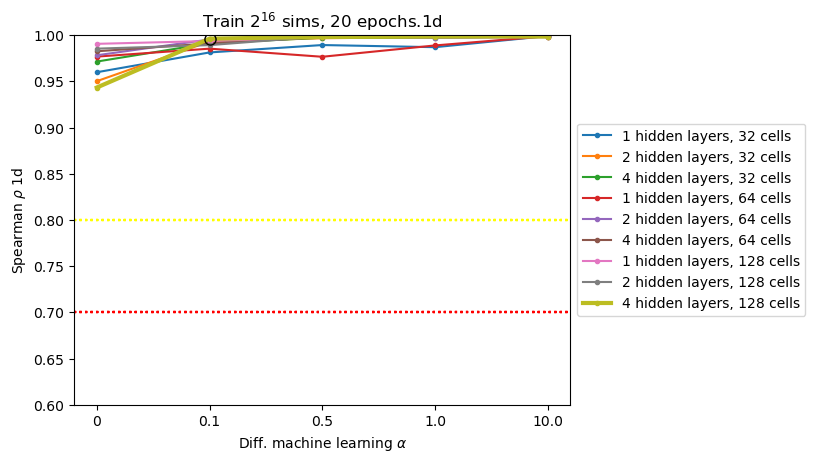

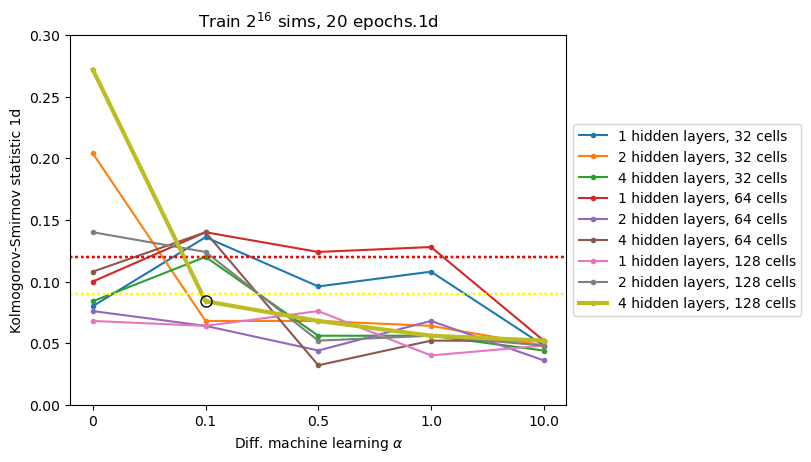

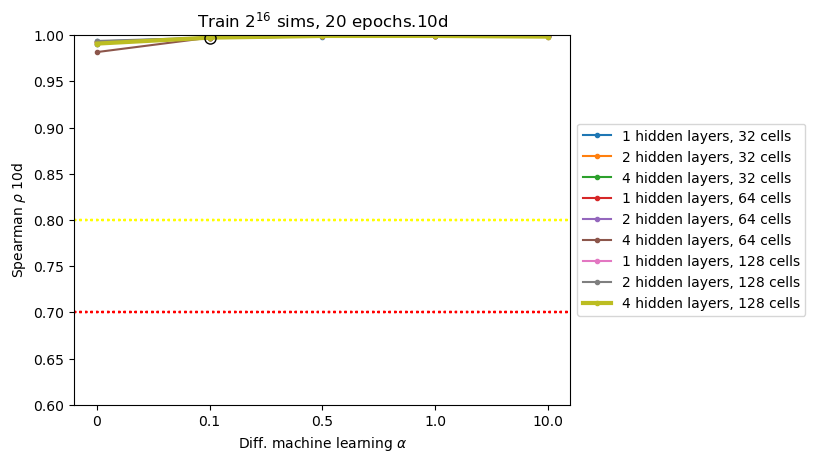

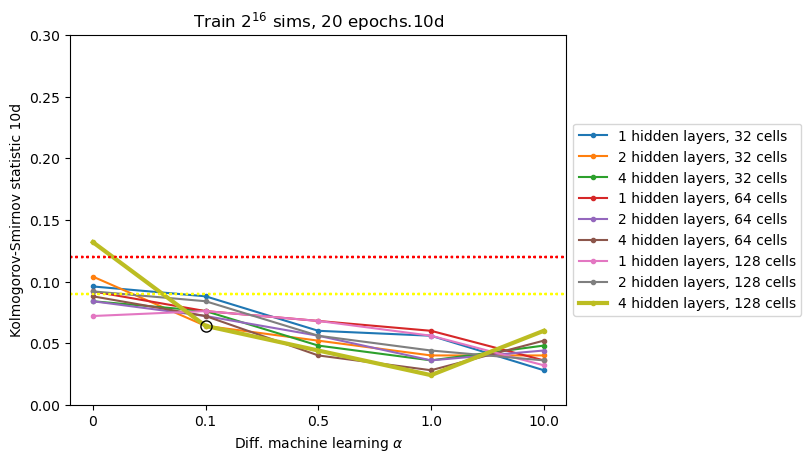

<Figure size 640x480 with 0 Axes>

In [66]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios_data][1:] 

if PATH_MODELS == 'MODELS_VR/RED_SIMS_NO_EARLY/':
    chart_name = r'Train $2^{14}$ sims, 20 epochs.'
    file_name = 'Reduced_No_Early_'
elif PATH_MODELS == 'MODELS_VR/EARLY/':
    chart_name = r'Train $2^{16}$ sims, early stopping.'
    file_name = 'Full_Early_'
elif PATH_MODELS == 'MODELS_VR/NO_EARLY/':
    chart_name = r'Train $2^{16}$ sims, 20 epochs.'
    file_name = 'Full_No_Early_'
elif PATH_MODELS == 'MODELS_VR/RED_SIMS_EARLY/':
    chart_name = r'Train $2^{14}$ sims, early stopping.'
    file_name = 'Reduced_Early_'
    
file_name = 'VR_Hedge_' + file_name

ModelHandlers.plot_model_results(metrics, best_model_metrics,alphas, cells_layer, num_hidden_layers, test_scenario_names, 
                                 bayes_error_cv, file_name, chart_name, "",PATH_FIGS)